In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import resample
from tpot.builtins import StackingEstimator

import os
import random
from copy import copy
from functools import partial

random.seed(0)
np.random.seed(0)

PLOTS_DIR = 'plots'

In [2]:
df = pd.read_csv('CRT_clean.csv')
df.head()

,ACT,batball,3flips,widgets,trucks,lilypads,water,giftwrap,Jerry,IQ,...,school_UM (dearborn),Sex_Male,RACE_Asian,RACE_Black,RACE_Latino,RACE_Other,RACE_White,Prestige_low,Prestige_middle,CRT
0,26.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,0,0,0,0,1,1,0,0.0
1,23.0,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,...,1,0,0,1,0,0,0,1,0,2.0
2,27.0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,...,1,1,0,0,0,0,1,1,0,1.0
3,22.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,1,0,0,0,1,0,0.0
4,31.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,...,1,1,0,0,0,1,0,1,0,3.0


In [3]:
n, n_cols = df.shape
print('Numer of observations: {}'.format(n))
print('Number of features: {}'.format(n_cols-1))

Numer of observations: 529
Number of features: 24


In [4]:
df[['CRT', 'ACT', 'IQ', '3.4K v 3.8K(2)']].describe()

,CRT,ACT,IQ,3.4K v 3.8K(2)
count,529.000000,529.000000,529.000000,529.000000
mean,0.903592,26.338374,2.510397,0.489603
std,0.973205,3.978739,2.134756,0.500365
min,0.000000,15.000000,0.000000,0.000000
25%,0.000000,24.000000,1.000000,0.000000
50%,1.000000,27.000000,2.000000,0.000000
75%,2.000000,29.000000,4.000000,1.000000
max,3.000000,36.000000,8.000000,1.000000


In [5]:
df[['CRT', 'ACT', 'IQ', '3.4K v 3.8K(2)']].corr()

,CRT,ACT,IQ,3.4K v 3.8K(2)
CRT,1.000000,0.477019,0.845099,0.233242
ACT,0.477019,1.000000,0.528836,0.190611
IQ,0.845099,0.528836,1.000000,0.260302
3.4K v 3.8K(2),0.233242,0.190611,0.260302,1.000000


In [6]:
class Baseline():
    def __init__(self, prediction=None):
        self.prediction = prediction
    
    def fit(self, X, y):
        self.prediction = round(y.mean())
        return self
        
    def predict(self, X):
        return self.prediction * np.ones(shape=X.shape[0])
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_params(self, *args, **kwargs):
        return {'prediction': self.prediction}
    
base = Baseline()

logit = LogisticRegression()
    
pipeline_clf = make_pipeline(
    FeatureAgglomeration(affinity="euclidean", linkage="ward"),
    StackingEstimator(
        estimator=SGDClassifier(
            alpha=0.0, 
            eta0=0.1, 
            fit_intercept=False, 
            l1_ratio=0.5, 
            learning_rate="constant", 
            loss="perceptron", 
            penalty="elasticnet", 
            power_t=0.5
        )
    ),
    StackingEstimator(
        estimator=MLPClassifier(alpha=0.001, learning_rate_init=1.0)
    ),
    ExtraTreesClassifier(
        bootstrap=False, 
        criterion="entropy", 
        max_features=0.3, 
        min_samples_leaf=7, 
        min_samples_split=13, 
        n_estimators=100
    )
)

In [7]:
y_var = '3.4K v 3.8K(2)'
X = df.drop(columns=y_var).to_numpy()
CRT = df['CRT'].to_numpy().reshape((-1, 1))
y = df[y_var].to_numpy()

kf = KFold()

def get_xval_scores(X=X, CRT=CRT, y=y):
    xval_scores = {'base': [], 'logit': [], 'pipeline': []}
    for train_idx, test_idx in kf.split(X, CRT, y):
        X_train, X_test, CRT_train, CRT_test, y_train, y_test = (
            X[train_idx], X[test_idx], 
            CRT[train_idx], CRT[test_idx],
            y[train_idx], y[test_idx]
        )
        xval_scores['base'].append(base.fit(X_train, y_train).score(X_test, y_test))
        xval_scores['logit'].append(logit.fit(CRT_train, y_train).score(CRT_test, y_test))
        xval_scores['pipeline'].append(pipeline_clf.fit(X_train, y_train).score(X_test, y_test))
    return {key: sum(val)/len(val) for key, val in xval_scores.items()}

xval_scores = get_xval_scores()
print('Xval accuracy baseline model: {:.4f}'.format(xval_scores['base']))
print('Xval accuracy logit: {:.4f}'.format(xval_scores['logit']))
print('Xval accuracy pipeline: {:.4f}'.format(xval_scores['pipeline']))

Xval accuracy baseline model: 0.4803
Xval accuracy logit: 0.5935
Xval accuracy pipeline: 0.6162


In [8]:
BOOTSTRAP_SAMPLES = 1000

def compute_improvement():
    X_b, CRT_b, y_b = resample(X, CRT, y)
    scores = get_xval_scores(X_b, CRT_b, y_b)
    return scores['pipeline']/scores['base'] - 1, scores['pipeline']/scores['logit'] - 1

def print_improvement(a):
    a = np.array(a)
    print('Average improvement: {:.4f}'.format(a.mean()))
    print('p={:.3f}'.format((a<=0).mean()))

pipe_v_base, pipe_v_logit = [], []
for i in range(BOOTSTRAP_SAMPLES):
    improvement = compute_improvement()
    pipe_v_base.append(improvement[0])
    pipe_v_logit.append(improvement[1])
    if i % 50 == 0:
        print('\nIteration: {}'.format(i))
        print('Pipeline versus baseline')
        print_improvement(pipe_v_base)
        print('Pipeline versus logit')
        print_improvement(pipe_v_logit)
 
print('\nFinal results')
print('Pipeline versus baseline')
print_improvement(pipe_v_base)
print('Pipeline versus logit')
print_improvement(pipe_v_logit)


Iteration: 0
Pipeline versus baseline
Average improvement: 0.1822
p=0.000
Pipeline versus logit
Average improvement: 0.1430
p=0.000

Iteration: 50
Pipeline versus baseline
Average improvement: 0.3018
p=0.000
Pipeline versus logit
Average improvement: 0.0759
p=0.000

Iteration: 100
Pipeline versus baseline
Average improvement: 0.2985
p=0.000
Pipeline versus logit
Average improvement: 0.0801
p=0.030

Iteration: 150
Pipeline versus baseline
Average improvement: 0.2946
p=0.000
Pipeline versus logit
Average improvement: 0.0805
p=0.020

Iteration: 200
Pipeline versus baseline
Average improvement: 0.2915
p=0.000
Pipeline versus logit
Average improvement: 0.0816
p=0.020

Iteration: 250
Pipeline versus baseline
Average improvement: 0.2904
p=0.000
Pipeline versus logit
Average improvement: 0.0827
p=0.016

Iteration: 300
Pipeline versus baseline
Average improvement: 0.2915
p=0.000
Pipeline versus logit
Average improvement: 0.0836
p=0.013

Iteration: 350
Pipeline versus baseline
Average improveme

Bootstrapped mean improvement: 0.087
Bootstrapped 95% CI: 0.019, 0.160
p=0.009


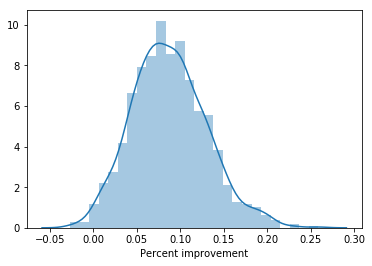

In [9]:
pct_improvement = np.array(pipe_v_logit)
print('Bootstrapped mean improvement: {:.3f}'.format(pct_improvement.mean()))
print('Bootstrapped 95% CI: {:.3f}, {:.3f}'.format(
    np.quantile(pct_improvement, .05), np.quantile(pct_improvement, .95)
))
print('p={:.3f}'.format((pct_improvement<=0).mean()))
sns.distplot(pct_improvement, axlabel='Percent improvement')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_improvement.png'), bbox_inches='tight')
plt.show()

In [10]:
pipeline_clf.fit(X, y)
print('Pipeline training accuracy: {:.3f}'.format(pipeline_clf.score(X, y)))

Pipeline training accuracy: 0.673


In [11]:
def model(X, predict_proba=False):
    X = pd.DataFrame(X, columns=X_cols)
    X = pd.get_dummies(X, columns=['school', 'Sex', 'RACE', 'Prestige'])
    X['CRT'] = X[['batball', 'widgets', 'lilypads']].sum(axis=1)
    X = X.drop(columns='Sex_Female')
    if predict_proba:
        return pipeline_clf.predict_proba(X)[:,1]
    return pipeline_clf.predict(X)

df = pd.read_csv('CRT_nodummies.csv')
X = df.drop(columns=y_var)
X_cols = [col for col in df.columns if col != y_var]

In [12]:
g = lambda y_pred: accuracy_score(y, y_pred)
explainer = gshap.KernelExplainer(model, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)

In [13]:
g_comparison, g_background = explainer.compare(X, bootstrap_samples=100)
print('Training accuracy: {:.4f}'.format(g_comparison))
print('Accuracy with shuffled training data: {:.4f}'.format(g_background))
print('Sum of G-SHAP values: {:.4f}'.format(gshap_values.sum()))

Training accuracy: 0.6730
Accuracy with shuffled training data: 0.5009
Sum of G-SHAP values: 0.1725


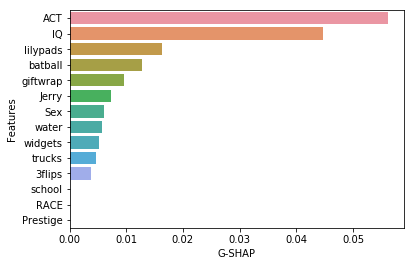

In [14]:
gshap_df = pd.DataFrame({'Features': X_cols, 'G-SHAP': gshap_values})
gshap_df = gshap_df.sort_values('G-SHAP', ascending=False)
sns.barplot(y='Features', x='G-SHAP', data=gshap_df)
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_gshap.png'), bbox_inches='tight')
plt.show()

In [15]:
gshap_df.reset_index(drop=True)

,Features,G-SHAP
0,ACT,0.056257
1,IQ,0.044764
2,lilypads,0.016333
3,batball,0.012798
4,giftwrap,0.009660
5,Jerry,0.007316
6,Sex,0.006106
7,water,0.005766
8,widgets,0.005123
9,trucks,0.004688


In [16]:
CRT_cols = ['Jerry', 'batball', 'lilypads', 'water', 'widgets', 'trucks', '3flips', 'giftwrap']
CRT_gshap = gshap_df[gshap_df['Features'].isin(CRT_cols)].sum()
print('Sum of G-SHAP values for CRT items: {:.4f}'.format(CRT_gshap[1]))

Sum of G-SHAP values for CRT items: 0.0654


In [17]:
predict_proba = partial(model, predict_proba=True)

CRT = df[CRT_cols].sum(axis=1)
g = lambda output: np.corrcoef(output, CRT)[0][1]
explainer = gshap.KernelExplainer(predict_proba, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)
gshap_values *= np.corrcoef(y, CRT)[0][1]

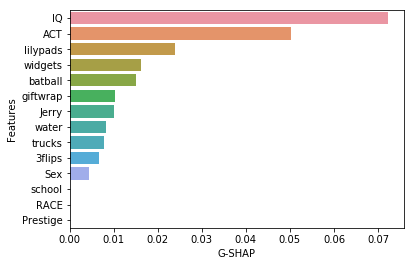

In [18]:
gshap_df = pd.DataFrame({'Features': X_cols, 'G-SHAP': gshap_values})
gshap_df = gshap_df.sort_values('G-SHAP', ascending=False)
sns.barplot(y='Features', x='G-SHAP', data=gshap_df)
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_corr_gshap.png'), bbox_inches='tight')
plt.show()

In [19]:
gshap_df.reset_index(drop=True)

,Features,G-SHAP
0,IQ,0.072358
1,ACT,0.050293
2,lilypads,0.023820
3,widgets,0.016096
4,batball,0.015149
5,giftwrap,0.010414
6,Jerry,0.010032
7,water,0.008160
8,trucks,0.007883
9,3flips,0.006652


In [20]:
CRT_gshap = gshap_df[gshap_df['Features'].isin(CRT_cols)].sum()
print('Sum of G-SHAP values for CRT items: {:.4f}'.format(CRT_gshap[1]))

Sum of G-SHAP values for CRT items: 0.0982
